In [1]:
!pip install numpy
!pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt

#Define your parameters:

#Length of orthogonal scintillators
L=0.3

#This is the maximum detectable angle in degrees,leads to the height between scint. layers by h=L/tan(θ_max)
theta_max=60 

#Minimum and maximum detectable muons energy(in GeV):
E_min=1
E_max=50

#Number of possible energy values(this depends on SiPM's accuracy):
N_E=6

#For a random sample define 1,for a perfect CM distribution 0:
random=1

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/home/tsexos/jupyter/environment/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/home/tsexos/jupyter/environment/bin/python -m pip install --upgrade pip' command.


In [4]:
#This creates random samples given a probabillity distribution function.The reason we need this approach 
#is that we have to create a probabillistic background that is constructed like a MC simulation. 

def MetropolisHastings(pdf, N, x_init, sigma):
    chain_points=np.zeros((N,x_init.shape[0]))
    stepsize=sigma
    accepted=0
    x_old=x_init
    for i in range(N):
      x_new =np.random.uniform(low=x_old-(1/2)*stepsize,high=x_old+(1/2)*stepsize,size=x_old.shape)
      p_accept=min(1, pdf(x_new)/pdf(x_old))
      accept = (np.random.random()<p_accept)
      if accept:
        x_old=x_new
      chain_points[i,:]=x_old
      accepted += accept

    acceptance_rate = accepted / float(N)
    print("For proposal width=",sigma,"acceptance rate=",acceptance_rate)
    return chain_points

In [5]:
#This creates the theta probabillity distribution,returning 0 probabillity for angles biger than the detectable range.
def pdf_theta(x,theta=60):
    if (x>(np.pi*theta/180)) or (x<0):
        return 0
    return np.cos(x)**2

#Normalisation of the energy distribution,regarding that we have fixed number of events in the [E_min,E_max].
def norm(E_min,E_max,n,theta):
    dE=(E_max-E_min)/(n-1)
    e_k=115
    e_p=850
    E=E_min
    sum=0
    for i in range (n):
        sum+=0.14*dE*(E**(-2.7))*(((1/(1+1.1*E*np.cos(theta)/e_p))+(0.054/(1+1.1*E*np.cos(theta)/e_k))))
        E+=dE
    return sum

#Energy probabillity distribution:
def pdf_e(E,E_min=1,E_max=100,theta=0,n=10):
    E_norm=norm(E_min,E_max,n,theta)
    if (E<E_min) or (E>E_max):
        return 0
    dE=(E_max-E_min)/(n-1)
    e_k=115
    e_p=850
    p=0.14*dE*(E**(-2.7))*(((1/(1+1.1*E*np.cos(theta)/e_p))+(0.054/(1+1.1*E*np.cos(theta)/e_k))))
    return p/E_norm



For proposal width= 0.1 acceptance rate= [0.966363]


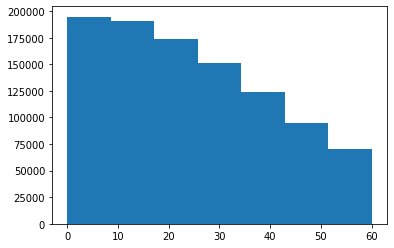

In [6]:
x_init=np.array([1])
y=MetropolisHastings(pdf_theta, 1000000, x_init, 0.1)
w=plt.hist(y*(180/np.pi),bins=7)

Text(0, 0.5, 'Number of events')

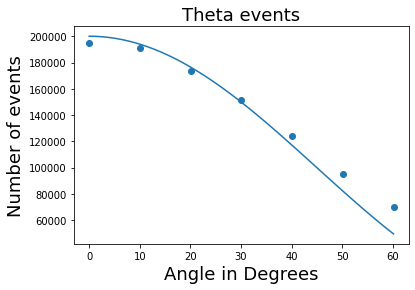

In [7]:
d=np.linspace(0,1.05,7)
plt.scatter(d*(180/np.pi),w[0])

x=np.linspace(0,1.05,100)
plt.plot(x*(180/np.pi),200000*np.cos(x)**2)
plt.title("Theta events" , fontsize=18)
plt.xlabel('Angle in Degrees', fontsize=18)
plt.ylabel('Number of events', fontsize=18)

For proposal width= 10 acceptance rate= [0.20554754]


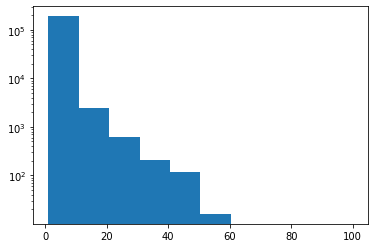

In [8]:
x_init=np.array([30])
y=MetropolisHastings(pdf_e, int(w[0][0]), x_init,10 )
bins=np.linspace(1,100,11)
energy=plt.hist(y,bins=bins)
plt.yscale("log")

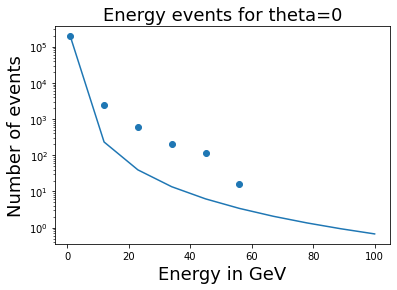

In [9]:
enn=np.linspace(1,100,10)
plt.scatter(enn,energy[0])
plt.title("Energy events for theta=0" , fontsize=18)
plt.xlabel('Energy in GeV', fontsize=18)
plt.ylabel('Number of events', fontsize=18)


p=np.zeros(10)
for i in range (10):
    p[i]=pdf_e(enn[i])


plt.plot(enn,energy[0].sum()*p)
#plt.xscale("log")
plt.yscale("log")

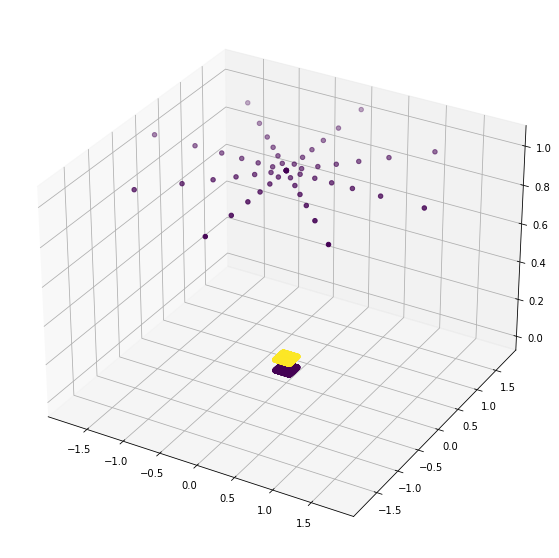

In [12]:
def source(s_h,n_theta,n_phi,L=0.1,theta_max=60*np.pi/180):    
    h=L/np.tan(theta_max)
    z=np.ones((n_theta,n_phi))*(h/2+s_h)
    x=np.zeros((n_theta,n_phi))
    y=np.zeros((n_theta,n_phi))
    directionx=np.zeros((n_theta,n_phi))
    directiony=np.zeros((n_theta,n_phi))
    directionz=np.zeros((n_theta,n_phi))
    theta=np.linspace(0,theta_max,n_theta)
    phi=np.linspace(0,2*np.pi-2*np.pi/n_phi,n_phi)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for i in range (n_theta):
        R=z[0,0]*np.tan(theta[i])
        for j in range (n_phi):
            x[i,j]=R*np.cos(phi[j])
            y[i,j]=R*np.sin(phi[j])
            directionx[i,j]=-np.sin(theta[i])*np.cos(phi[j])
            directiony[i,j]=-np.sin(theta[i])*np.sin(phi[j])
            directionz[i,j]=-np.cos(theta[i])
            #scat=ax.plot([0,x[i,j]],[0,y[i,j]],[h/2,z[0,0]])
    X, Y, Z = np.mgrid[-L:L:100j, -L:L:100j, 0:h:2j]
    scat = ax.scatter(x, y, z, c=z.flatten())
    scat = ax.scatter(X, Y, Z, c=Z.flatten())

    return x,y,z,directionx,directiony,directionz

x,y,z,dx,dy,dz=source(1,7,8)

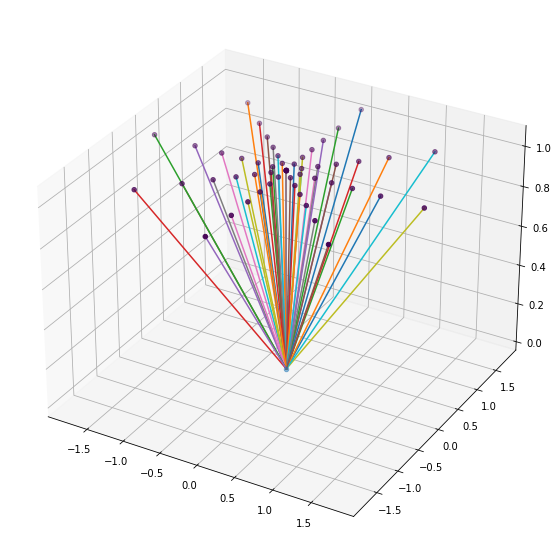

In [13]:
L=0.1
h=L/np.tan(1.05)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(0, 0, h/2, alpha=0.5)
for i in range (7):
        for j in range (8):
            scat=ax.plot([0,x[i,j]],[0,y[i,j]],[h/2,z[0,0]])

scat = ax.scatter(x, y, z, c=z.flatten())



In [19]:
#Simple regression algorithm

def MLP(hhidden,Y=Y,X=X):  #Y:Energy, X:theta,phi,pulse peak
  model = torch.nn.Sequential(torch.nn.Linear(3, hhidden), torch.nn.ReLU(), torch.nn.Linear(hhidden, 1))

  optimizer = torch.optim.Adam(model.parameters(), lr =0.001) 
  Loss=torch.nn.MSELoss()
  loss_hist = []
  nbatch = 32
  nepochs = 1200
  for epoch in range(nepochs): 
    for i in range(len(X)//nbatch):
      X_scaled_batch = X[i*nbatch:(i+1)*nbatch]
      y_batch = Y[i*nbatch:(i+1)*nbatch]
 
      optimizer.zero_grad()
 
      y_pred = model(X_scaled_batch).squeeze(1)
 
      loss = Loss(y_pred, y_batch)

      loss.backward()
      optimizer.step()
    loss_hist.append(loss.item())
  plt.plot(loss_hist)
  plt.show()
  y_pred= model(X).squeeze(1).detach().numpy()
  return y_pred

NameError: name 'Y' is not defined

In [61]:
def source2(n_theta,n_phi,L,theta_max=60*np.pi/180,s_h=10):    
    h=L/np.tan(theta_max)
    z=np.ones((n_theta,n_phi,9))*(h/2+s_h)
    x=np.zeros((n_theta,n_phi,9))
    y=np.zeros((n_theta,n_phi,9))
    directionx=np.zeros((n_theta,n_phi,9))
    directiony=np.zeros((n_theta,n_phi,9))
    directionz=np.zeros((n_theta,n_phi,9))
    theta=np.linspace(0,theta_max,n_theta)
    phi=np.linspace(0,2*np.pi-2*np.pi/n_phi,n_phi)
    q1=np.array([0,0,0,1,1,1,-1,-1,-1])
    q2=np.array([0,-1,1,0,1,-1,0,1,-1])
    
    for i in range (n_theta):
        R=z[0,0,0]*np.tan(theta[i])
        for j in range (n_phi):
            for k in range (9):
                #print(q1[k],q2[k])
                x[i,j,k]=R*np.cos(phi[j])+q1[k]*(L/3)
                y[i,j,k]=R*np.sin(phi[j])+q2[k]*(L/3)
            
                dx=-np.sin(theta[i])*np.cos(phi[j])
                dy=-np.sin(theta[i])*np.sin(phi[j])
                dz=-np.cos(theta[i])
                if (x[i,j,k]<L/2) or (x[i,j,k]>-L/2) or (y[i,j,k]>-L/2) or (y[i,j,k]<L/2):
                    directionx[i,j,k]=dx
                    directiony[i,j,k]=dy
                    directionz[i,j,k]=dz

    return x,y,z,directionx,directiony,directionz

In [75]:
x,y,z,dx,dy,dz=source2(7,8,L,theta_max=60*np.pi/180,s_h=4)

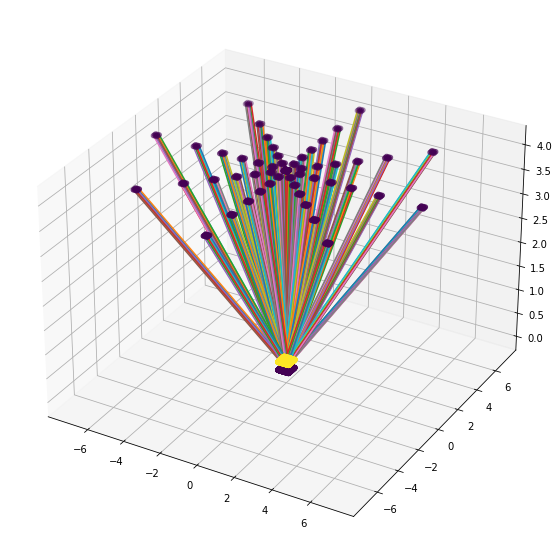

In [77]:
q1=np.array([0,0,0,1,1,1,-1,-1,-1])
q2=np.array([0,-1,1,0,1,-1,0,1,-1])
L=0.3
h=L/np.tan(1.05)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range (7):
        for j in range (8):

            scat=ax.plot([0,x[i,j,0]],[0,y[i,j,0]],[h/2,z[0,0,0]])
            scat=ax.plot([0,x[i,j,1]],[-L/3,y[i,j,1]],[h/2,z[0,0,0]])
            scat=ax.plot([0,x[i,j,2]],[L/3,y[i,j,2]],[h/2,z[0,0,0]])
            scat=ax.plot([L/3,x[i,j,3]],[0,y[i,j,3]],[h/2,z[0,0,0]])
            scat=ax.plot([L/3,x[i,j,4]],[L/3,y[i,j,4]],[h/2,z[0,0,0]])
            scat=ax.plot([L/3,x[i,j,5]],[-L/3,y[i,j,5]],[h/2,z[0,0,0]])
            scat=ax.plot([-L/3,x[i,j,6]],[0,y[i,j,6]],[h/2,z[0,0,0]])
            scat=ax.plot([-L/3,x[i,j,7]],[L/3,y[i,j,7]],[h/2,z[0,0,0]])
            scat=ax.plot([-L/3,x[i,j,8]],[-L/3,y[i,j,8]],[h/2,z[0,0,0]])

#plt.xlim(-0.3,0.3)
#scat = ax.scatter(x[:,:,1], y[:,:,1], z[:,:,1])            
#scat = ax.scatter(x[:,:,2], y[:,:,2], z[:,:,2]) #, c=z.flatten())
X, Y, Z = np.mgrid[-L:L:100j, -L:L:100j, 0:h:2j]
scat = ax.scatter(x, y, z, c=z.flatten())
scat = ax.scatter(X, Y, Z, c=Z.flatten())